In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
from itertools import groupby

import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

import networkx as nx

from minimal.imaging import draw_plan, blit_rooms
from minimal.layout import NodeType, NODE_COLOR, NODE_NAME
from minimal import sample_graphs
from minimal.gen import _load_segmentation_dict
from minimal.lib import gen_segmentation_mask, assemble_plan
from minimal.doors import create_cut_wall_mask

from minimal.walls import (
    CC_T,
    CC_R,
    CC_B,
    CC_L,
    CC_TL,
    CC_TR,
    CC_BR,
    CC_BL,
)
%matplotlib inline

In [3]:
layout, masks = _load_segmentation_dict(torch.load("data/rgm_04.pth"))

In [4]:
# %%time

# masks = gen_segmentation_mask(layout)

In [5]:
scale = (3, 3)

In [6]:
%%time

rect_graphs, wall_runs, doors, sep_mask = assemble_plan(layout, masks, scale)

CPU times: user 361 ms, sys: 3 ms, total: 364 ms
Wall time: 278 ms


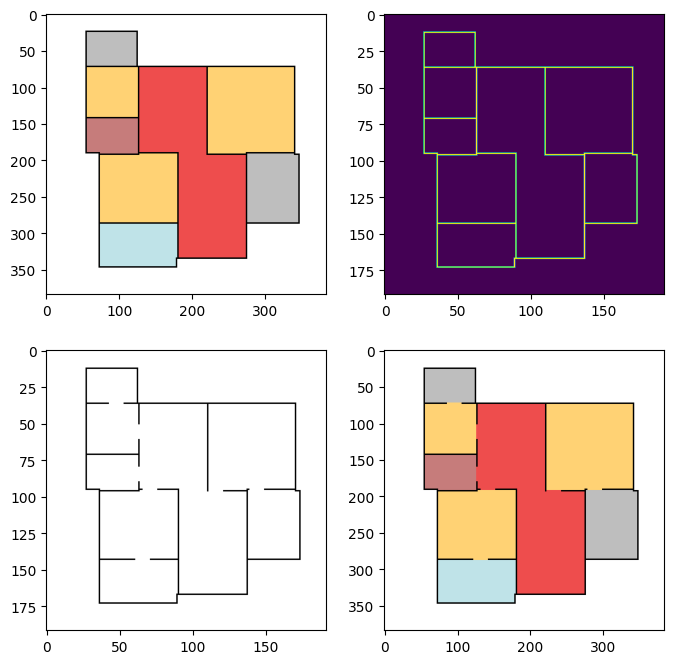

In [7]:
walls = create_cut_wall_mask(sep_mask, doors)

plt.figure(figsize=(8,8))

plt.subplot(221)
plt.imshow(blit_rooms(rect_graphs, sep_mask, out_size=384))

plt.subplot(222)
plt.imshow((sep_mask > 0).byte())

plt.subplot(223)
plt.imshow(1 - walls, cmap="gray")

plt.subplot(224)
plt.imshow(blit_rooms(rect_graphs, walls, out_size=384))

In [8]:
rooms_encoded = []
for i, r in enumerate(rect_graphs):
    room_data = [r.room_type]
    for _, d in r.rects_graph.nodes(data=True):
        room_data.extend(d['xywh'])

    rooms_encoded.append(room_data)

In [9]:
plan_json = json.dumps({
    'shape': tuple(sep_mask.shape),
    'scale': scale,
    "rooms": rooms_encoded,
    "walls": wall_runs,
    "doors": doors
})
# print(plan_json)

In [10]:
with open("plan.json", "w") as f:
    f.write(plan_json)

In [11]:
from minimal.walls import all_wall_runs
# len(wall_runs)

In [12]:
wall_runs = all_wall_runs([
    (sep_mask & CC_T).bool(),
    (sep_mask & CC_R).bool(),
    (sep_mask & CC_B).bool(),
    (sep_mask & CC_L).bool(),
])
print(len(wall_runs))

23


In [13]:
wall_runs = all_wall_runs([
    ((sep_mask & CC_T) | (sep_mask == CC_TR) | (sep_mask == CC_TL)).bool(),
    ((sep_mask & CC_R) | (sep_mask == CC_TR) | (sep_mask == CC_BR)).bool(),
    ((sep_mask & CC_B) | (sep_mask == CC_BR) | (sep_mask == CC_BL)).bool(),
    ((sep_mask & CC_L) | (sep_mask == CC_TL) | (sep_mask == CC_BL)).bool(),
])
print(len(wall_runs))

23


In [14]:
# plt.figure(figsize=(12,12))
# plt.imshow(sep_mask > 0)

In [15]:
# from minimal.imaging import draw_sep_nask_wireframe
# draw_sep_nask_wireframe(sep_mask)